In [1]:
from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv
from baselines.common.vec_env.dummy_vec_env import DummyVecEnv
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import copy
import random
import gym

%matplotlib inline

In [2]:
tf.reset_default_graph()
sess = tf.Session()

In [3]:
def copy_net(name1, name2):
    variables = tf.trainable_variables()
    for var1 in variables:
        if name2+"/" in var1.name:
            trained_var = [var2 for var2 in tf.trainable_variables() if var2.op.name in str.replace(var1.name, name2+"/", name1+"/")][0]
            value = sess.run(trained_var)
            sess.run(tf.assign(var1, value))

In [4]:
class QualityNet:
    def __init__(self, **kwargs):
        with tf.variable_scope(kwargs.get("net_name")+"/"):
            self.action_space_size = kwargs.get("action_space_size", 3)
            self.observation_space_size = kwargs.get("observation_space_size", 2)
            state_queue_size = kwargs.get("state_queue_size", 1) #TODO: set qsize from QLearning Class

            layers_config = kwargs.get("layers_config", (self.action_space_size + state_queue_size*self.observation_space_size, 32)) 

            self.input_state = tf.placeholder(tf.float32, shape=[None, state_queue_size, self.observation_space_size], name="input_state")
            self.flattened_state = tf.reshape(self.input_state, [-1, self.observation_space_size * state_queue_size])
            self.input_action = tf.placeholder(tf.int32, shape=[None], name="input_action")
            input_action_one_hot = tf.one_hot(self.input_action, depth=self.action_space_size)
            
            self.input_data = tf.concat([self.flattened_state, input_action_one_hot], 1)
            
            self.input_layer = tf.layers.dense(self.input_data, units=layers_config[0], activation='relu')
            self.hidden_layer = tf.layers.dense(self.input_layer, units=layers_config[1], activation = 'relu')
            self.output_layer = tf.layers.dense(self.hidden_layer, units=1)
            
            self.exp_value = tf.placeholder(tf.float32, name="exp_value") #  shape=[None] WTF???
            self.loss = tf.losses.mean_squared_error(self.exp_value, self.output_layer)
            
            optimizer = tf.train.RMSPropOptimizer(0.1)
            self.train_op = optimizer.minimize(self.loss)
        
    def train(self, batch):
        global sess
        input_state = [batch[:, 0][i] for i in range(len(batch))]
        input_action = batch[:, 1]
        
        _, loss = sess.run((self.train_op, self.loss), 
                           feed_dict = {
                                self.input_state: input_state,
                                self.input_action: input_action,
                                self.exp_value: batch[:, 4],
                            })
        return loss
        
    def feed_forward(self, states_list, action):
        global sess
        output = sess.run((self.output_layer), feed_dict = {self.input_state: states_list, self.input_action: action})
        return output
    
    def predict_actions(self, state_queues):
        states_input = np.repeat(np.array(state_queues), repeats=self.action_space_size, axis=0)
        actions_input = np.tile(range(self.action_space_size), len(state_queues))
        
        qvalues = self.feed_forward(states_input, actions_input)
        qvalues = qvalues.reshape(len(qvalues) // self.action_space_size, self.action_space_size)  
        return np.argmax(qvalues, axis=1)

    def get_max_q(self, batch):
        states_input = np.repeat(batch[:, 3], repeats=self.action_space_size, axis=0)
        actions_input = np.tile(np.arange(self.action_space_size), len(batch))
        qvalues = self.feed_forward(np.array(states_input.tolist()), actions_input)
        qvalues = qvalues.reshape(len(qvalues) // self.action_space_size, self.action_space_size) 
        return np.max(qvalues, axis=1)
        
class QLearning:
    def __init__(self, env_name, **kwargs):
        self.stochastic_action_likelihood = kwargs.get("stoch_act_ch", 0.6)
        self.stochastic_action_likelihood_d = kwargs.get("stoch_act_ch_d", 0.001) #TODO: adaptive stoch_action_l_d; endpoint: 0.1
        self.discount = kwargs.get("discount", 0.99)
        self.rewards = []

        self.nproc = kwargs.get("nproc", 30)
        self.envs = DummyVecEnv([self.make_env(env_name, seed) for seed in range(self.nproc)]) #Dummy
        
        # This code gets action and observation space sizes for 1D tasks
        self.action_space_size = self.envs.action_space.n if isinstance(self.envs.action_space, gym.spaces.discrete.Discrete) else self.envs.action_space.shape[0]
        self.observation_space_size = self.envs.observation_space.n if isinstance(self.envs.observation_space, gym.spaces.discrete.Discrete) else self.envs.observation_space.shape[0]
        
        env_data = {
            "observation_space_size": self.observation_space_size,
            "action_space_size": self.action_space_size,
        }
        
        prediction_net_params = kwargs.get("prediction_net_params", {})
        prediction_net_params["net_name"] = "prediction_net"
        prediction_net_params.update(env_data)
        self.prediction_net = QualityNet(**prediction_net_params)
        
        train_net_params = kwargs.get("train_net_params", {})
        train_net_params["net_name"] = "train_net"
        train_net_params.update(env_data)
        self.train_net = QualityNet(**train_net_params)
        
    def update_state(self, state_queue, val):
        state_queue.pop()
        state_queue.insert(0, val)

    def batch_generator(self, state_queue_size, batch_size, history_size):
        """
            history[0] = queue of four last states
            history[1] = action
            history[2] = reward
            history[3] = states queue with new state
        """
        self.rewards = []
        qstates = [[np.random.sample(len(self.envs.observation_space.sample())) for _ in range(state_queue_size)] for _ in range(self.nproc)] #observation_space_size refactor
        trajectories = [np.empty((0, 4)) for _ in range(self.nproc)]
        
        history = np.empty((0, 5))
        observations = self.envs.reset()
        for pid in range(self.nproc):
            self.update_state(qstates[pid], observations[pid])

        while True:
            history = history[batch_size:]
            while len(history) < history_size:
                if random.random() < self.stochastic_action_likelihood:
                    actions = np.stack([self.envs.action_space.sample() for _ in range(self.nproc)]) # test
                else:
                    actions = self.prediction_net.predict_actions(qstates)
                observations, rewards, dones, _ = self.envs.step(actions)

                for pid in range(self.nproc):
                    new_state = copy.deepcopy(qstates[pid])
                    self.update_state(new_state, observations[pid])
                    
                    trajectories[pid] = np.vstack((trajectories[pid], [qstates[pid], actions[pid], rewards[pid], new_state]))
                    
                    if dones[pid]:
                        qvalues = self.prediction_net.get_max_q(trajectories[pid][:-1])
                        qvalues *= self.discount
                        qvalues = qvalues + trajectories[pid][:-1][:, 2]
                        qvalues = np.append(qvalues, rewards[pid])
                        new_history = np.hstack((trajectories[pid], np.expand_dims(qvalues, axis=-1)))
                        
                        self.rewards.append(trajectories[pid][:-1][:, 2].sum() + rewards[pid])
                        trajectories[pid] = np.empty((0, 4))
                        history = np.vstack((history, new_history))
                                    
            np.random.shuffle(history)
            yield history[np.random.choice(history.shape[0], size=batch_size), :]

    def make_env(self, env_id, seed):
        nproc = self.nproc
        def _f():

            env = gym.make(env_id)
            env.seed(seed)

            # Desync environments
            env.reset()
            for i in range(int(env.spec.max_episode_steps*seed//nproc)):
                env.step(env.action_space.sample())
            return env
        return _f
    
    def run(self, iterations=10000, batch_size=64, state_window=1, update_net_period=50, history_size=500):
        self.update_net_period = update_net_period
        loss_list = list()
        self.batch_gen = self.batch_generator(state_window, batch_size, history_size)
        
        for i in range(10):
            next(self.batch_gen)
        
        for i in tqdm_notebook(range(iterations)):
            batch = next(self.batch_gen)
            
            loss = self.train_net.train(batch)
            loss_list.append(loss)
            
            if i % self.update_net_period == 0:
                copy_net("train_net", "prediction_net")
            
            self.stochastic_action_likelihood -= self.stochastic_action_likelihood_d
        plt.plot(self.rewards)  
        
    def test(self, env_name):
        print(sess.run((self.prediction_net.output_layer), feed_dict={
            self.prediction_net.input_state: [[[0, 0]], [[0, 0]], [[0,0]]],
            self.prediction_net.input_action: [0, 1, 2],
        }))
        
        env = gym.make(env_name)
        observation = env.reset()
        
        trained_batch = next(self.batch_gen) 
        print("TRAINED BATCH:", trained_batch)
        
        for i in range(10000):
            try:
                action = self.prediction_net.predict_actions([[observation]])
                observation, reward, done, _ = env.step(action[0])    
                env.render()
                if done:
                    observation = env.reset()
            except KeyboardInterrupt:
                env.close()
                break


W0715 17:51:42.646511  1092 deprecation.py:323] From <ipython-input-4-44211c7da1ad>:17: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0715 17:51:42.671519  1092 deprecation.py:506] From C:\Users\suriknik\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0715 17:51:43.337502  1092 deprecation.py:323] From C:\Users\suriknik\Anaconda3\lib\site-packages\tensorflow\python\ops\losses\losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule

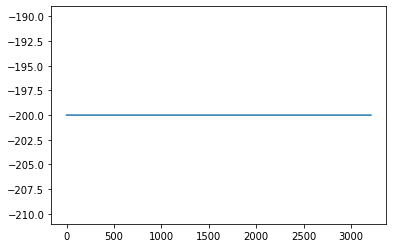

In [5]:
ql = QLearning("MountainCar-v0")

sess.run(tf.local_variables_initializer())
sess.run(tf.global_variables_initializer())

ql.run()

In [6]:
ql.test("MountainCar-v0")

[[-52.20361]
 [-52.20361]
 [-52.20361]]
TRAINED BATCH: [[list([array([-0.44839054,  0.        ], dtype=float32)]) 0 -1.0
  list([array([-0.57718706, -0.01035995], dtype=float32)])
  -52.63603210449219]
 [list([array([-0.43117407,  0.        ], dtype=float32)]) 0 -1.0
  list([array([-0.68254787,  0.00653965], dtype=float32)])
  -52.63603210449219]
 [list([array([-0.4474817,  0.       ], dtype=float32)]) 0 -1.0
  list([array([-0.57657194, -0.01165291], dtype=float32)])
  -52.63603210449219]
 [list([array([-0.45796514,  0.        ], dtype=float32)]) 0 -1.0
  list([array([-0.48805776, -0.00199165], dtype=float32)])
  -52.63603210449219]
 [list([array([-0.5552024,  0.       ], dtype=float32)]) 0 -1.0
  list([array([-0.5819099 ,  0.01035775], dtype=float32)])
  -52.63603210449219]
 [list([array([-0.5463389,  0.       ], dtype=float32)]) 0 -1.0
  list([array([-0.5888504 ,  0.01758138], dtype=float32)])
  -52.63603210449219]
 [list([array([-0.46078435,  0.        ], dtype=float32)]) 0 -1.0
  l

  -52.370574951171875]]
